
# USA Housing Market — End-to-End ML Use Case
**Synthetic but realistic data, EDA, predictive modeling, prescriptive pricing, and feedback monitoring**

This notebook creates a rich, U.S.-focused synthetic housing dataset (10k+ rows) with macro + local features, runs EDA, trains a price model, proposes **optimal list prices** (prescriptive optimization), and simulates **market drift** (mortgage rate & inventory shifts) with monitoring.



## Contents
1. Data generation (U.S. geography & market variables)  
2. EDA (distributions, relationships)  
3. Predictive modeling (sold price)  
4. Prescriptive pricing (optimize list price)  
5. Feedback loop + drift (changing mortgage rates, inventory)  
6. Monitoring (rolling MAE, PSI drift)  



## 1) Data Generation — U.S. Housing (Synthetic)


In [1]:

import numpy as np, pandas as pd
rng = np.random.default_rng(2025)

states = [
    ("CA","San Francisco-Oakland-SJ", 37.77, -122.42),
    ("CA","Los Angeles-Long Beach", 34.05, -118.24),
    ("TX","Dallas-Fort Worth", 32.78, -96.8),
    ("TX","Austin-Round Rock", 30.27, -97.74),
    ("FL","Miami-Fort Lauderdale", 25.76, -80.19),
    ("NY","New York-Newark-Jersey", 40.71, -74.01),
    ("IL","Chicago-Naperville", 41.88, -87.63),
    ("WA","Seattle-Tacoma", 47.61, -122.33),
    ("MA","Boston-Cambridge", 42.36, -71.06),
    ("GA","Atlanta-Sandy Springs", 33.75, -84.39),
]
property_types = ["single_family","condo","townhouse"]
n = 12000

def sample_geo(i):
    st, metro, lat, lon = states[i % len(states)]
    lat_j = lat + rng.normal(0, 0.3)
    lon_j = lon + rng.normal(0, 0.3)
    zip3 = int(abs((lat_j*100 + lon_j*10)) % 999)
    return st, metro, zip3, lat_j, lon_j

rows = []
for i in range(n):
    st, metro, zip3, lat, lon = sample_geo(i + rng.integers(0,1000))
    ptype = rng.choice(property_types, p=[0.6, 0.25, 0.15])
    year_built = int(rng.integers(1940, 2024))
    age = 2024 - year_built
    sqft = float(np.clip(rng.normal(2200 if ptype=="single_family" else 1100, 400), 450, 6500))
    beds = int(np.clip(rng.normal(3.2 if ptype=="single_family" else 2.0, 0.8), 1, 7))
    baths = float(np.clip(rng.normal(2.2 if ptype=="single_family" else 1.5, 0.6), 1, 5))
    lot = float(np.clip(rng.normal(6500 if ptype=="single_family" else 0, 3000), 0, 20000))
    garage = int(rng.random() < (0.8 if ptype!="condo" else 0.3))
    hoa = float(np.clip(rng.normal(55 if ptype!="single_family" else 20, 25), 0, 350))
    school = float(np.clip(rng.normal(7.0, 1.8), 1, 10))
    crime = float(np.clip(rng.normal(4.0, 1.5), 1, 10))
    walk = float(np.clip(rng.normal(55, 20), 0, 100))
    month = int(rng.integers(1,13))
    season = np.sin(2*np.pi*(month-1)/12)
    mortgage = float(np.clip(rng.normal(6.5, 0.7), 3.0, 10.0))
    unemp = float(np.clip(rng.normal(4.8, 1.2), 2.0, 9.0))
    inventory = float(np.clip(rng.normal(2.8, 1.0), 0.5, 8.0))
    dom = float(np.clip(rng.normal(30 + 10*(inventory-3), 12), 5, 150))
    metro_base = {
        "San Francisco-Oakland-SJ": 950000,
        "Los Angeles-Long Beach":   820000,
        "Seattle-Tacoma":           780000,
        "Boston-Cambridge":         750000,
        "New York-Newark-Jersey":   900000,
        "Chicago-Naperville":       450000,
        "Dallas-Fort Worth":        420000,
        "Austin-Round Rock":        520000,
        "Miami-Fort Lauderdale":    600000,
        "Atlanta-Sandy Springs":    380000,
    }[metro]
    struct = 120*sqft + 8000*beds + 7000*baths + 3*lot + 15000*garage - 1200*age
    hood = 35000*(school-5) - 20000*(crime-5) + 1200*(walk-50)
    macro = -8000*(mortgage-5) - 3000*(unemp-4.5) - 12000*(inventory-3) + 10000*season
    true_value = metro_base + 0.7*struct + 0.6*hood + macro + rng.normal(0, 25000)
    list_price_strategy = rng.normal(1.03, 0.03)
    list_price = float(np.clip(true_value * list_price_strategy, 80000, 3_500_000))
    demand_factor = 0.07*(school-5) - 0.05*(crime-5) + 0.001*(walk-50) - 0.04*(mortgage-5) - 0.03*(inventory-3) + 0.04*season
    sold_ratio = np.clip(1.00 + demand_factor + rng.normal(0, 0.03), 0.9, 1.12)
    sold_price = float(np.clip(list_price * sold_ratio, 80000, 4_000_000))

    rows.append({
        "state": st, "metro": metro, "zip3": zip3, "lat": lat, "lon": lon,
        "property_type": ptype, "year_built": year_built, "age": age,
        "sqft": sqft, "beds": beds, "baths": baths, "lot_sqft": lot,
        "has_garage": garage, "hoa_fee": hoa,
        "school_rating": school, "crime_index": crime, "walk_score": walk,
        "month": month, "season": season,
        "mortgage_rate": mortgage, "unemployment_rate": unemp,
        "months_inventory": inventory, "days_on_market": dom,
        "list_price": list_price, "sold_price": sold_price, "true_value": true_value
    })

df = pd.DataFrame(rows)
df.shape


(12000, 26)


## 2) EDA — Distributions & Relationships


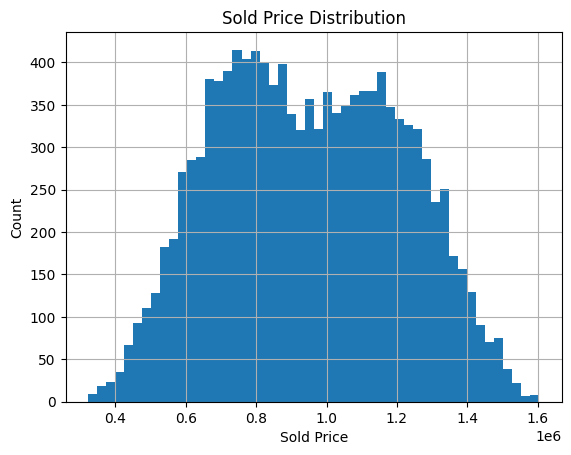

In [2]:

import matplotlib.pyplot as plt

plt.figure()
df["sold_price"].hist(bins=50)
plt.title("Sold Price Distribution"); plt.xlabel("Sold Price"); plt.ylabel("Count"); plt.show()


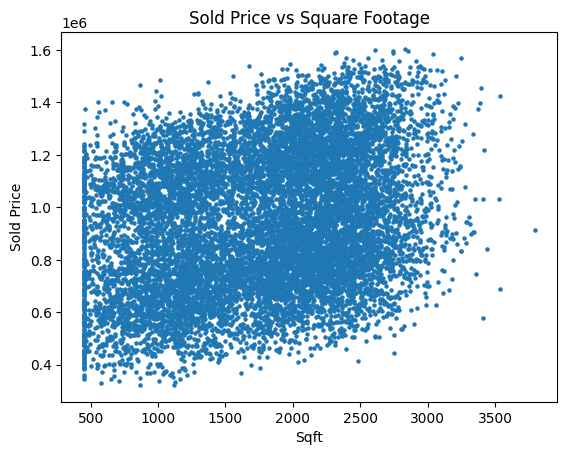

In [3]:

plt.figure()
plt.scatter(df["sqft"], df["sold_price"], s=5)
plt.title("Sold Price vs Square Footage"); plt.xlabel("Sqft"); plt.ylabel("Sold Price"); plt.show()


In [4]:

num_cols = ["sold_price","list_price","sqft","beds","baths","age","hoa_fee","school_rating","crime_index","walk_score","mortgage_rate","unemployment_rate","months_inventory","days_on_market"]
corr = df[num_cols].corr(numeric_only=True)
corr.loc[["sold_price"]].T.sort_values("sold_price", ascending=False).head(15)


,sold_price
sold_price,1.000000
list_price,0.971434
school_rating,0.334723
sqft,0.289313
beds,0.166059
baths,0.134240
walk_score,0.082586
unemployment_rate,-0.020566
mortgage_rate,-0.050893
days_on_market,-0.063458



## 3) Predictive Modeling — Sold Price


In [5]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

target = "sold_price"
cat_cols = ["state","metro","property_type"]
num_cols = ["sqft","beds","baths","age","lot_sqft","has_garage","hoa_fee",
            "school_rating","crime_index","walk_score","month","season",
            "mortgage_rate","unemployment_rate","months_inventory","days_on_market","list_price"]

X = df[cat_cols + num_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols),
])

model = Pipeline([
    ("pre", pre),
    ("gb", GradientBoostingRegressor(random_state=42))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
(mae, r2)


(17184.169002758998, 0.99122610633446)

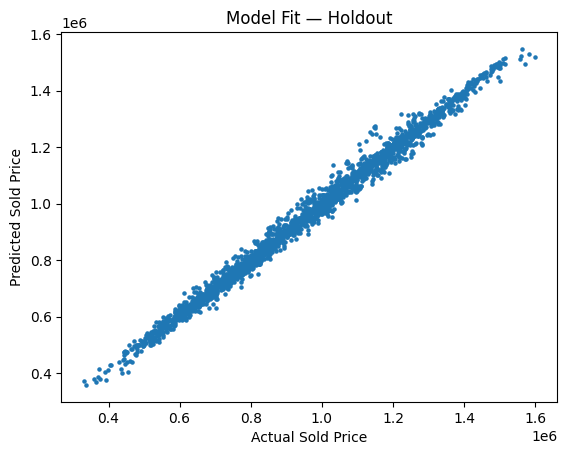

In [6]:

plt.figure()
plt.scatter(y_test, pred, s=5)
plt.xlabel("Actual Sold Price"); plt.ylabel("Predicted Sold Price"); plt.title("Model Fit — Holdout")
plt.show()



## 4) Prescriptive Pricing — Optimize List Price via Grid


In [7]:

sample = df.sample(1, random_state=1).iloc[0]
base = sample.copy()

def predict_sold_for_list(lp, record):
    x = record.copy()
    x["list_price"] = lp
    cols = ["state","metro","property_type","sqft","beds","baths","age","lot_sqft","has_garage","hoa_fee",
            "school_rating","crime_index","walk_score","month","season","mortgage_rate","unemployment_rate","months_inventory","days_on_market","list_price"]
    return float(model.predict(pd.DataFrame([x[cols]]))[0])

lp_grid = np.linspace(base["list_price"]*0.9, base["list_price"]*1.1, 41)
fees = 0.06
pred_sold = np.array([predict_sold_for_list(lp, base) for lp in lp_grid])
net_proceeds = pred_sold * (1 - fees)
best_idx = int(np.argmax(net_proceeds))
best_lp = float(lp_grid[best_idx]); best_sp = float(pred_sold[best_idx]); best_np = float(net_proceeds[best_idx])
(best_lp, best_sp, best_np)


(1068556.172043628, 1179265.98571759, 1108510.0265745346)

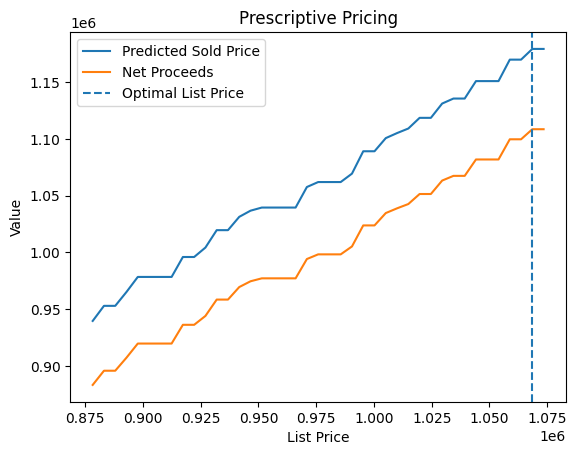

In [8]:

plt.figure()
plt.plot(lp_grid, pred_sold, label="Predicted Sold Price")
plt.plot(lp_grid, net_proceeds, label="Net Proceeds")
plt.axvline(best_lp, linestyle="--", label="Optimal List Price")
plt.xlabel("List Price"); plt.ylabel("Value"); plt.title("Prescriptive Pricing"); plt.legend(); plt.show()



## 5) Feedback Loop & Drift — Future Months


In [9]:
# pip install --upgrade scipy


In [10]:
import numpy as np
import pandas as pd

# --- KS import with fallback ---
try:
    from scipy.stats import ks_2samp as _ks_2samp
    def ks_stat(a, b):
        return float(_ks_2samp(a, b).statistic)
except Exception:
    # Pure NumPy fallback: two-sample KS statistic (D)
    def ks_stat(a, b):
        a = np.asarray(a); b = np.asarray(b)
        a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
        a.sort(); b.sort()
        na, nb = len(a), len(b)
        ia = ib = 0
        D = 0.0
        while ia < na and ib < nb:
            if a[ia] <= b[ib]:
                x = a[ia]
                while ia < na and a[ia] == x: ia += 1
            else:
                x = b[ib]
                while ib < nb and b[ib] == x: ib += 1
            Fa = ia / na
            Fb = ib / nb
            d = abs(Fa - Fb)
            if d > D: D = d
        # If one array has remaining mass:
        D = max(D, abs(1 - ib/nb)) if ia == na else max(D, abs(1 - ia/na))
        return float(D)

def psi(expected, actual, buckets=10):
    e_bins = np.quantile(expected, np.linspace(0,1,buckets+1))
    e_bins = np.unique(e_bins)
    if len(e_bins) <= 2:
        return 0.0
    e_hist, _ = np.histogram(expected, bins=e_bins)
    a_hist, _ = np.histogram(actual, bins=e_bins)
    e_pct = np.clip(e_hist / max(e_hist.sum(),1), 1e-6, None)
    a_pct = np.clip(a_hist / max(a_hist.sum(),1), 1e-6, None)
    return float(np.sum((a_pct - e_pct) * np.log(a_pct / e_pct)))



In [11]:

plt.figure()
plt.plot(metrics_df["month"], metrics_df["mae"])
plt.xlabel("Future Month"); plt.ylabel("MAE"); plt.title("MAE per Month (with drift)")
plt.show()


NameError: name 'metrics_df' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:

plt.figure()
plt.plot(metrics_df["month"], metrics_df["psi_list_price"], label="PSI(list_price)")
plt.plot(metrics_df["month"], metrics_df["ks_list_price"], label="KS(list_price)")
plt.xlabel("Future Month"); plt.ylabel("Drift Metric"); plt.title("List Price Drift"); plt.legend(); plt.show()


NameError: name 'metrics_df' is not defined

<Figure size 640x480 with 0 Axes>


## 6) Next Steps
- Add public datasets (ACS, FHFA HPI, mortgage series) when available
- Try **LightGBM/XGBoost** for speed/accuracy
- Add **spatial features** (distance to downtown, parks, transit)
- Deploy: model registry + scheduled retraining + alerting
